### Introduction
This final project explores the best locations for Indian restaurants throughout the city of New York. New York is a major metropolitan area with more than 8.4 million people living within city limits. Additionally, I will attempt to answer the questions “Where should I open an Indian Restaurant?” and “Where should I stay If I want great Indian food?”

### Data
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of Indian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

### Methodology
• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Indian restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings

• Finally, the data be will be visually assessed using graphing from various Python libraries.

### Problem Statement
What is / are the best location(s) for Indian cuisine in New York City?  
In what Neighborhood and/or borough should I open an Indian restaurant to have the best chance of being successful?  
Where would I go in New York City to have the best Indian food?

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
!pip install folium
import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Libraries imported!')

     |████████████████████████████████| 102kB 8.3MB/s ta 0:00:011
Libraries imported!


In [2]:
CLIENT_ID = 'K2I5NPFJ1S354FSQKPLXECMIAKQHUDYQXEPLHPVN20OTUXB1' 
CLIENT_SECRET = 'YEUV5UISNCY2WYLEZBDTYDNJJ1GZGYU5PVGPN4CBJFUFME5H' 
VERSION = '20190605' 

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    print(url)
    results = requests.get(url).json()
    print(results)
    try:
        venue_data=results["response"]['groups'][0]['items']
    except:
        print("Some Exception")
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    # function to fetch New York dataset
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [4]:
ny_data = get_new_york_data()
ny_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

### Now that we have our initial data, lets start analyzing it. We can see below that Manhattan has the least number of neighborhoods in all five buroughs.

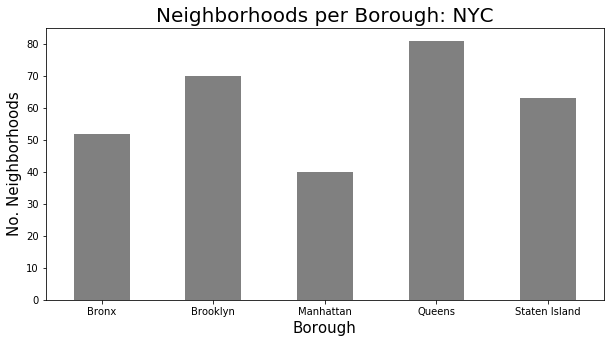

In [5]:
clr = "grey"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

### Lets analyze further and see how many indian restaurants are there in each neighborhood and burough and graph the results.

In [6]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

https://api.foursquare.com/v2/venues/explore?&client_id=K2I5NPFJ1S354FSQKPLXECMIAKQHUDYQXEPLHPVN20OTUXB1&client_secret=YEUV5UISNCY2WYLEZBDTYDNJJ1GZGYU5PVGPN4CBJFUFME5H&v=20190605&ll=40.89470517661,-73.84720052054902&radius=400&limit=100
{'meta': {'code': 200, 'requestId': '5ef1c96040a7ea001b3432d2'}, 'response': {'headerLocation': 'Wakefield', 'headerFullLocation': 'Wakefield, Bronx', 'headerLocationGranularity': 'neighborhood', 'totalResults': 6, 'suggestedBounds': {'ne': {'lat': 40.89830518021001, 'lng': -73.84244696112977}, 'sw': {'lat': 40.89110517301, 'lng': -73.85195407996828}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c537892fd2ea593cb077a28', 'name': 'Lollipops Gelato', 'location': {'address': '4120 Baychester Ave', 'crossStreet': 'Edenwald & Bussing Ave', 'lat': 40.894123150205274, 'lng': -73.8

UnboundLocalError: local variable 'venue_data' referenced before assignment

In [7]:
# Save the information so far to a .csv file due to limited calls on FourSquare
indian_rest_ny.to_csv('indianRestaurants.csv')

In [8]:
indian_rest_ny = pd.read_csv('indianRestaurants.csv')
indian_rest_ny.head()

Unnamed: 0   Borough Neighborhood                        ID  \
0           0     Bronx     Woodlawn  4c0448d9310fc9b6bf1dc761   
1           1     Bronx    Unionport  4c194631838020a13e78e561   
2           2  Brooklyn    Bay Ridge  545835a1498e820edc6f636f   
3           3  Brooklyn   Greenpoint  51a5445c498ee0f182370cb2   
4           4  Brooklyn     Bushwick  5169f5c4e4b0c7fcb77a0f3c   

                          Name  
0                   Curry Spot  
1  Melanies Roti Bar And Grill  
2                 Bombay Grill  
3               Agra Taj Mahal  
4                 Agra Heights

### As we continue our analysis, we see below that although Manhattan had the least number of nieghborhoods, it does have the highest number if Indian restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Greenwich Village has the highest number of Indian restaurants in all of NYC.

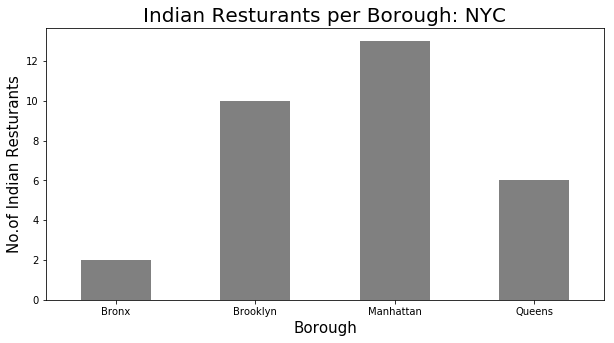

In [9]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Indian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

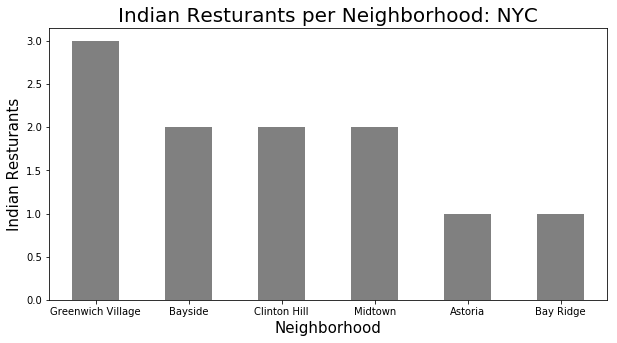

In [10]:
NOofNeigh = 6 # top number for graphing all the same past 6
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [11]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Greenwich Village']

Unnamed: 0    Borough       Neighborhood                        ID  \
20          20  Manhattan  Greenwich Village  56c931b2cd10407d3ecbefda   
21          21  Manhattan  Greenwich Village  4593ed04f964a52050401fe3   
22          22  Manhattan  Greenwich Village  4d992c1e942ba093ebb5968c   

                     Name  
20                 Ananda  
21  The Kati Roll Company  
22              THELEwala

In [12]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

In [13]:
for row in indian_rest_ny.values.tolist():
    print(row)
    ID1,Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

[0, 'Bronx', 'Woodlawn', '4c0448d9310fc9b6bf1dc761', 'Curry Spot']
{'meta': {'code': 200, 'requestId': '5ef1cc4a7828ae001bdf5b8d'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https:

In [14]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny_csv.csv')

In [15]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
Borough         31 non-null object
Neighborhood    31 non-null object
ID              31 non-null object
Name            31 non-null object
Likes           31 non-null float64
Rating          31 non-null float64
Tips            31 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.8+ KB


In [16]:
indian_rest_stats_ny.describe()

Likes     Rating        Tips
count   31.000000  31.000000   31.000000
mean    98.580645   7.493548   32.967742
std    190.264338   1.667920   56.600638
min      0.000000   0.000000    0.000000
25%     13.000000   7.350000    6.000000
50%     31.000000   8.000000   14.000000
75%     75.000000   8.300000   21.000000
max    834.000000   8.900000  258.000000

In [17]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.3
Tips                                 258
Name: 19, dtype: object

In [18]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               8.9
Tips                                 148
Name: 23, dtype: object

In [19]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.3
Tips                                 258
Name: 19, dtype: object

In [20]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Neighborhood  Average Rating
19                    Tribeca        8.900000
7                 Fort Greene        8.800000
23               West Village        8.600000
17  Prospect Lefferts Gardens        8.600000
10          Greenwich Village        8.566667
16                    Midtown        8.350000
0                     Astoria        8.300000
24                   Woodlawn        8.100000
3                 Boerum Hill        8.000000
21            Upper West Side        8.000000

In [21]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Borough  Average Rating
2  Manhattan        8.192308
1   Brooklyn        7.390000
0      Bronx        7.000000
3     Queens        6.316667

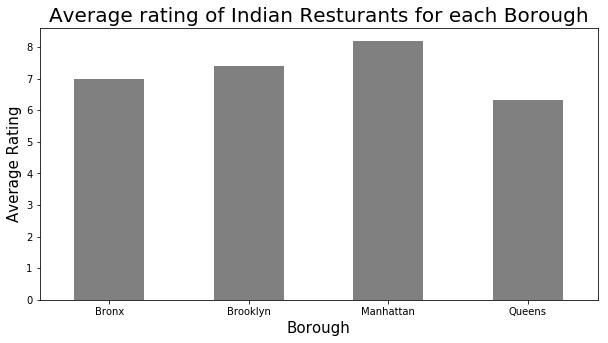

In [22]:
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Indian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

### We will visually map the neighborhoods with an average rating greater than or equal to 8 after joining the approprite dfs to include latitudes and longitudes.

In [23]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

Neighborhood  Average Rating
0                     Astoria        8.300000
3                 Boerum Hill        8.000000
7                 Fort Greene        8.800000
10          Greenwich Village        8.566667
12                Kew Gardens        8.000000
16                    Midtown        8.350000
17  Prospect Lefferts Gardens        8.600000
19                    Tribeca        8.900000
21            Upper West Side        8.000000
23               West Village        8.600000
24                   Woodlawn        8.100000

In [24]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

Borough               Neighborhood   Latitude  Longitude  Average Rating
0      Queens                    Astoria  40.768509 -73.915654        8.300000
1    Brooklyn                Boerum Hill  40.685683 -73.983748        8.000000
2    Brooklyn                Fort Greene  40.688527 -73.972906        8.800000
3   Manhattan          Greenwich Village  40.726933 -73.999914        8.566667
4      Queens                Kew Gardens  40.705179 -73.829819        8.000000
5   Manhattan                    Midtown  40.754691 -73.981669        8.350000
6    Brooklyn  Prospect Lefferts Gardens  40.658420 -73.954899        8.600000
7   Manhattan                    Tribeca  40.721522 -74.010683        8.900000
8   Manhattan            Upper West Side  40.787658 -73.977059        8.000000
9   Manhattan               West Village  40.734434 -74.006180        8.600000
10      Bronx                   Woodlawn  40.898273 -73.867315        8.100000

In [25]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [26]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [27]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


FileNotFoundError: [Errno 2] No such file or directory: 'Borough Boundaries.geojson'

### Finally, we will visualize all NYC buroughs based on average Rating.

#### Results / Conclusion
Manhattan and Queens have the best rated Indian restaurants on average. Queens and The Bronx have the least amount of Indian restaurants per borough. However, of note, Belmont of The Bronx is the neighborhood in all of NYC with the most Indian Restaurants. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most Indian restaurants. Based on this information, I would state that Manhattan and Queens are the best locations for Indian cuisine in NYC. To have the best shot of success, I would open an Indian restaurants in Queens. Queens has multiple neighborhoods with average ratings exceeding 8.0 of a scale of 1.0 to 10.0 and has the least number of Indian restaurants making competition easier than in other boroughs. Finally, I would go to Gramercy in Manhattan for the best Indian food based on 131 likes.